In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import ParameterGrid
from torch.utils.data import DataLoader
from vae.datasets_randomized import VolSurfaceDataSetRand, CustomBatchSampler
from vae.cvae_with_mem_randomized import CVAEMemRand
from vae.utils import *
from eval_scripts.eval_multi_day import *
import os

In [2]:
set_seeds(0)
torch.set_default_dtype(torch.float64)
num_epochs = 500
ctx_len = 4
start_day = ctx_len+1
days_to_generate = 3995
num_vaes = 1000

In [6]:
data = np.load("data/vol_surface_with_ret.npz")
vol_surf_data = data["surface"]
ret_data = data["ret"]
level_data = data["levels"]
skew_data = data["skews"]
slope_data = data["slopes"]
ex_data = np.concatenate([ret_data[...,np.newaxis], skew_data[...,np.newaxis], slope_data[...,np.newaxis]], axis=-1)
print(ex_data.shape)
train_dataset = VolSurfaceDataSetRand(vol_surf_data[:4000])
valid_dataset = VolSurfaceDataSetRand(vol_surf_data[4000:5000])
test_dataset = VolSurfaceDataSetRand(vol_surf_data[5000:])
train_batch_sampler = CustomBatchSampler(train_dataset, 64)
valid_batch_sampler = CustomBatchSampler(valid_dataset, 16)
test_batch_sampler = CustomBatchSampler(test_dataset, 16)
train_simple = DataLoader(train_dataset, batch_sampler=train_batch_sampler)
valid_simple = DataLoader(valid_dataset, batch_sampler=valid_batch_sampler)
test_simple = DataLoader(test_dataset, batch_sampler=test_batch_sampler)

train_dataset2 = VolSurfaceDataSetRand((vol_surf_data[:4000], ex_data[:4000]))
valid_dataset2 = VolSurfaceDataSetRand((vol_surf_data[4000:5000], ex_data[4000:5000]))
test_dataset2 = VolSurfaceDataSetRand((vol_surf_data[5000:], ex_data[5000:]))
train_batch_sampler2 = CustomBatchSampler(train_dataset2, 64)
valid_batch_sampler2 = CustomBatchSampler(valid_dataset2, 16)
test_batch_sampler2 = CustomBatchSampler(test_dataset2, 16)
train_ex = DataLoader(train_dataset2, batch_sampler=train_batch_sampler2)
valid_ex = DataLoader(valid_dataset2, batch_sampler=valid_batch_sampler2)
test_ex = DataLoader(test_dataset2, batch_sampler=test_batch_sampler2)

(5822, 3)


In [4]:
model_data = torch.load("test_spx/ex_3_feats/conv_mem_spx_ex3_0.pt") # latent_dim=5, surface_hidden=[5,5,5], mem_hidden=100
model_config = model_data["model_config"]
model = CVAEMemRand(model_config)
model.load_weights(dict_to_load=model_data)
print(model)

CVAEMemRand(
  (encoder): CVAEMemRandEncoder(
    (surface_embedding): Sequential(
      (enc_conv_0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_0): ReLU()
      (enc_conv_1): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_1): ReLU()
      (enc_conv_2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_2): ReLU()
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (ex_feats_embedding): Identity()
    (interaction): Identity()
    (mem): LSTM(128, 100, num_layers=2, batch_first=True, dropout=0.2)
    (z_mean_layer): Linear(in_features=100, out_features=5, bias=True)
    (z_log_var_layer): Linear(in_features=100, out_features=5, bias=True)
  )
  (ctx_encoder): CVAECtxMemRandEncoder(
    (ctx_surface_embedding): Sequential(
      (ctx_enc_conv_0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ctx_enc_activation_0): ReLU()
      (ctx_enc_co

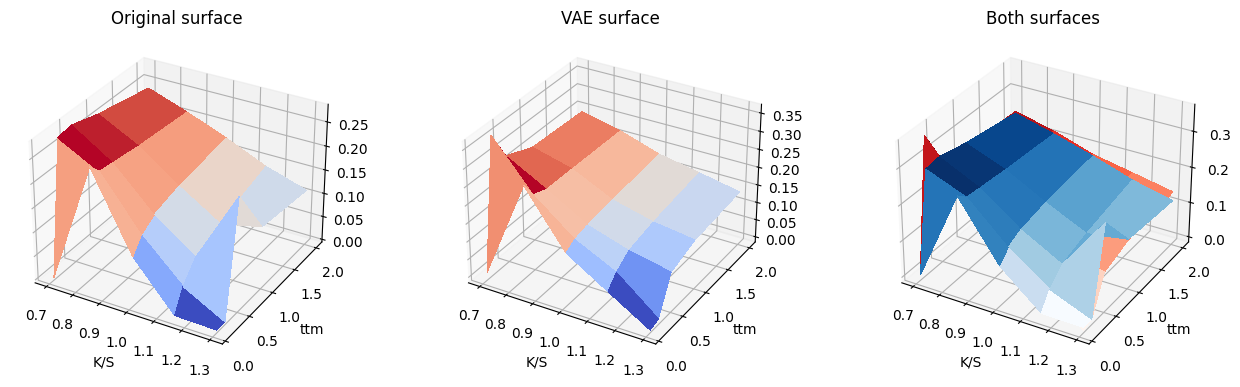

In [7]:
surf, ex_feat = model.get_surface_given_conditions({"surface": torch.from_numpy(vol_surf_data[5000:5004]),
                                    "ex_feats": torch.from_numpy(ex_data[5000:5004])})
surf = surf.detach().cpu().numpy().reshape((5,5))
# ex_feat = ex_feat.detach().cpu().numpy().reshape((1,))[0]
# print(f"Real return: {ret_data[5000+ctx_len]}, predicted: {ex_feat}")
plot_surface_separate(vol_surf_data[5004], surf)

(3995, 1000, 5, 5)


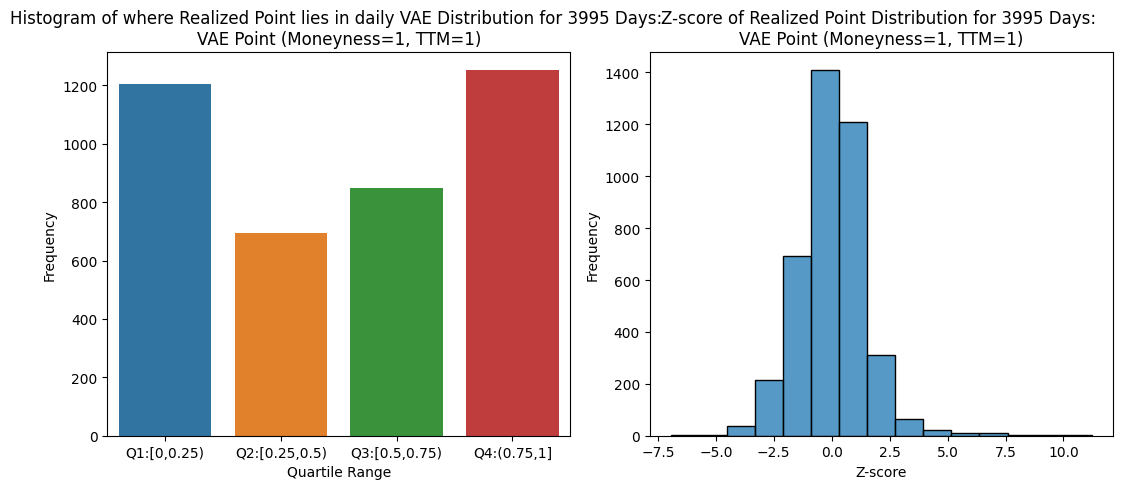

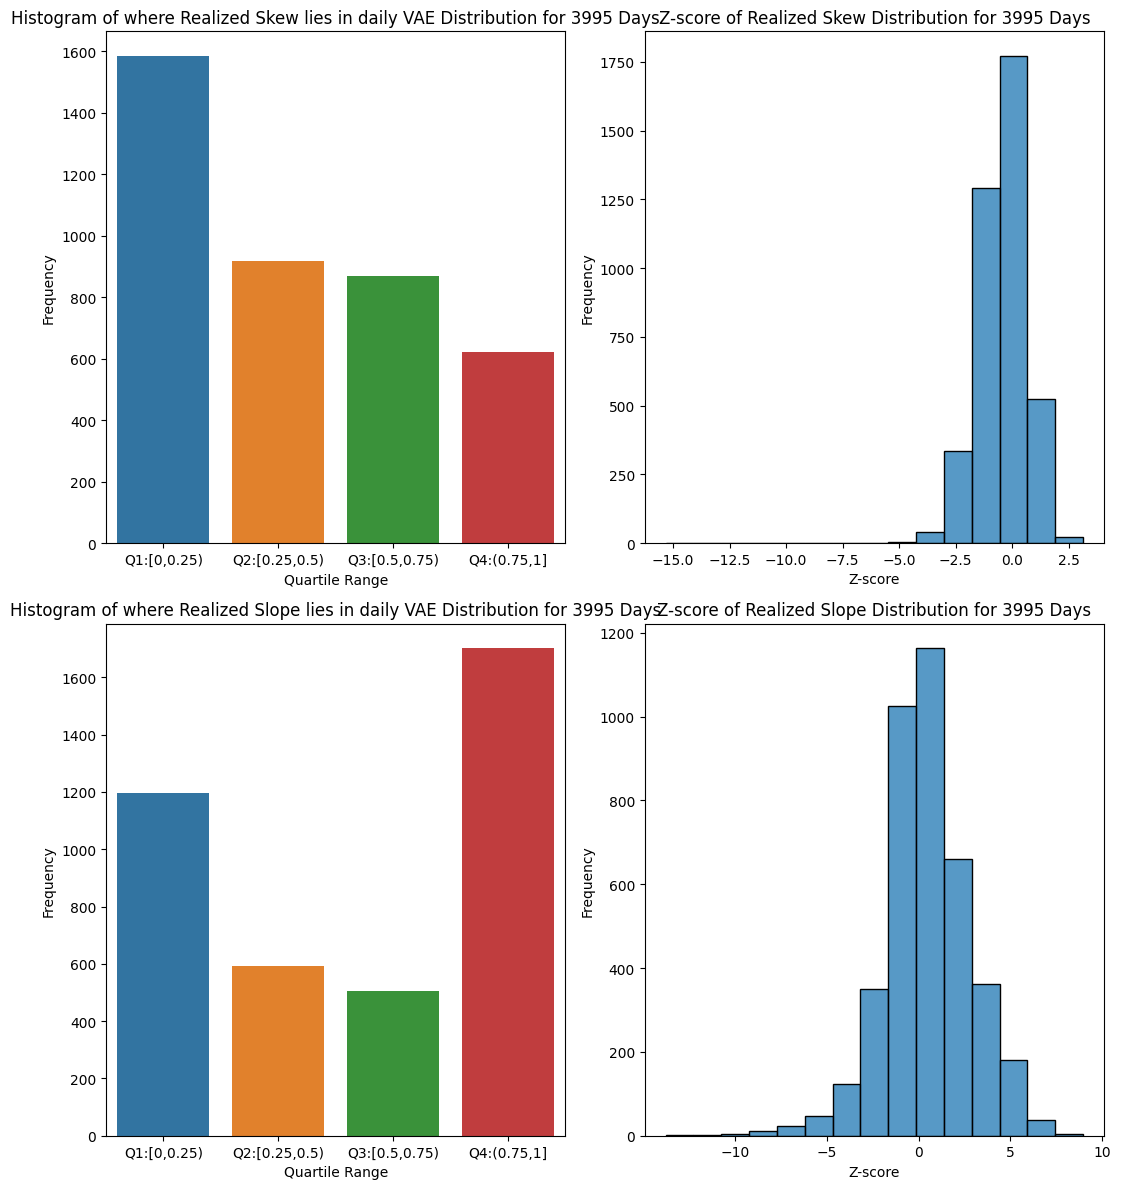

In [8]:
if not os.path.exists("test_spx/conv_mem_spx_ex3_0_gen2.npy"):
    surfaces, _ = generate_surfaces_multiday(model_data = model_data,
        ex_data = ex_data, vol_surface_data = vol_surf_data,
        start_day=start_day, days_to_generate=days_to_generate, num_vaes = num_vaes,
        model_type = CVAEMemRand, check_ex_feats=False, ctx_len=2)
    np.save("test_spx/conv_mem_spx_ex3_0_gen2.npy", surfaces)
else:
    surfaces = np.load("test_spx/conv_mem_spx_ex3_0_gen2.npy")

print(surfaces.shape)
_ = generate_multiple_surfaces_day_evolution_pre_gen(pre_generated_data={"surface": surfaces},
                                             vol_surface_data = vol_surf_data[start_day:start_day+days_to_generate],
                                             ex_data=ex_data[start_day:start_day+days_to_generate],
                                             row=3, col=2, check_ex_feats=False, bin_count=15)
_ = skew_and_slope_daily_evolution_pre_gen(pre_generated_data={"surface": surfaces},
                                           vol_surface_data=vol_surf_data[start_day:start_day+days_to_generate],
                                            bin_count=15)

(3995, 1000, 5, 5)


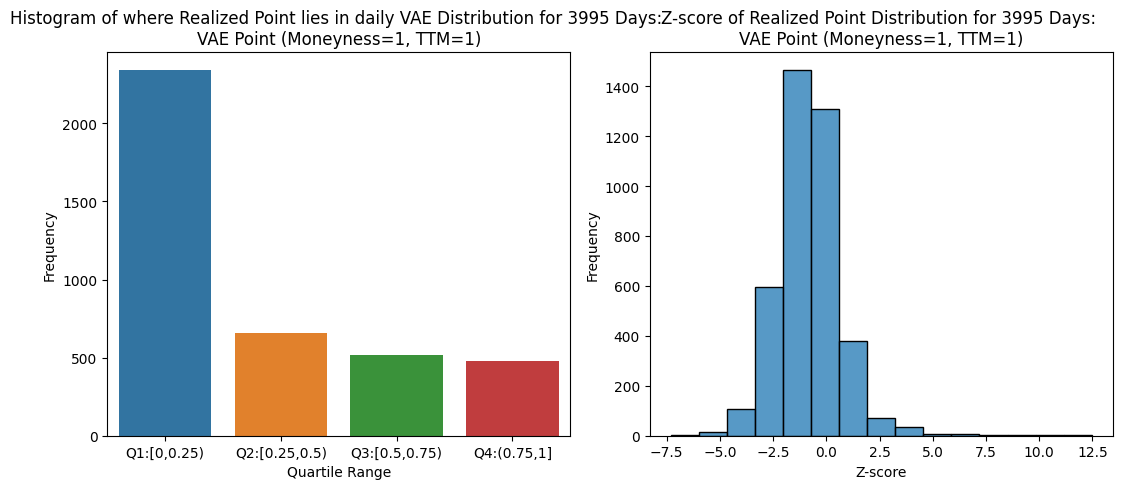

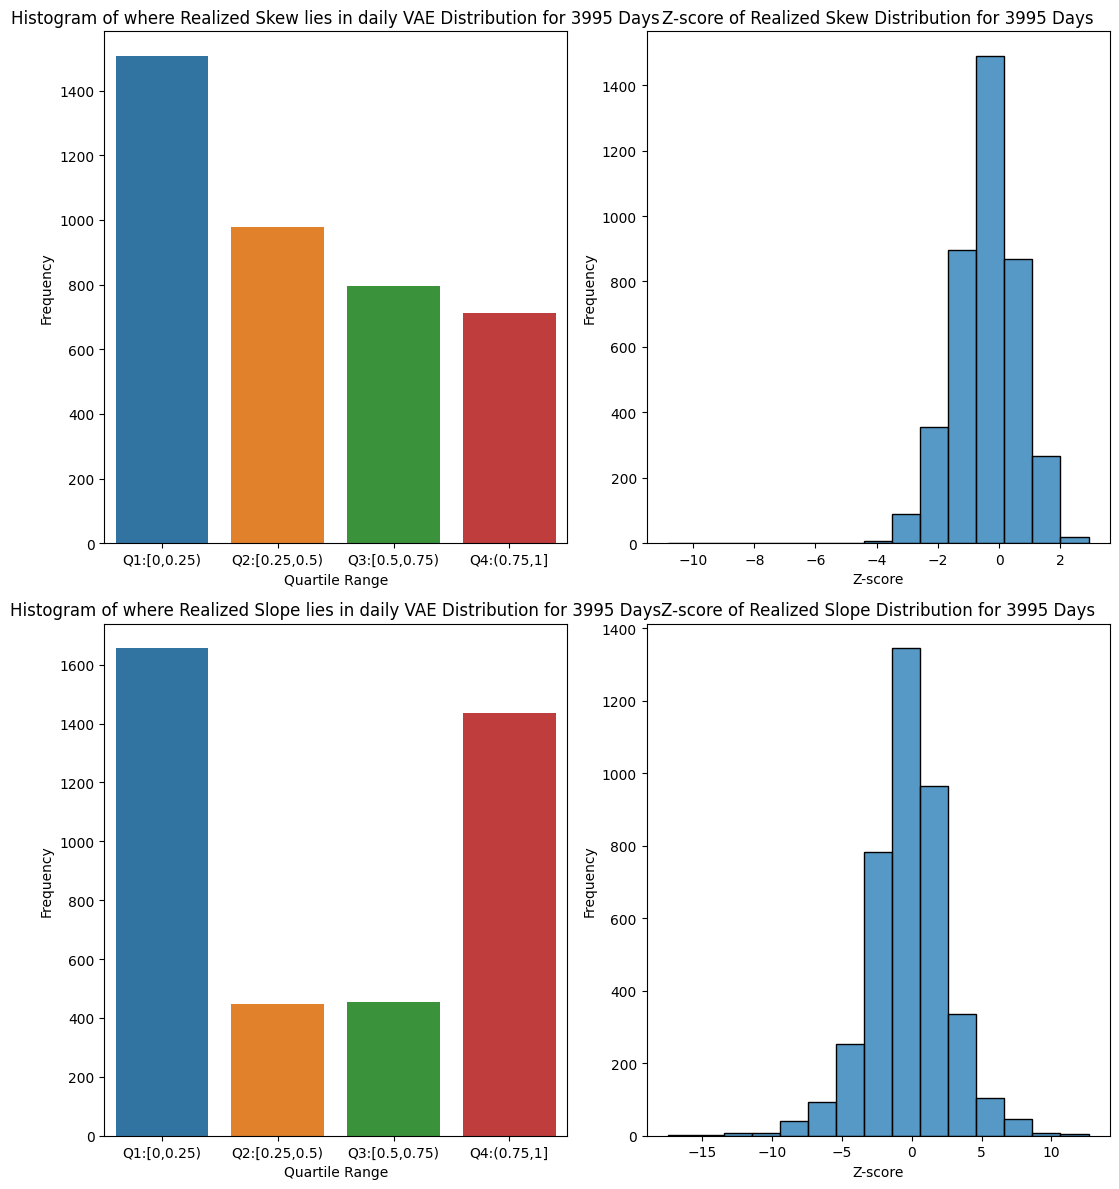

In [9]:
if not os.path.exists("test_spx/conv_mem_spx_ex3_0_gen3.npy"):
    surfaces, _ = generate_surfaces_multiday(model_data = model_data,
        ex_data = ex_data, vol_surface_data = vol_surf_data,
        start_day=start_day, days_to_generate=days_to_generate, num_vaes = num_vaes,
        model_type = CVAEMemRand, check_ex_feats=False, ctx_len=3)
    np.save("test_spx/conv_mem_spx_ex3_0_gen3.npy", surfaces)
else:
    surfaces = np.load("test_spx/conv_mem_spx_ex3_0_gen3.npy")

print(surfaces.shape)
_ = generate_multiple_surfaces_day_evolution_pre_gen(pre_generated_data={"surface": surfaces},
                                             vol_surface_data = vol_surf_data[start_day:start_day+days_to_generate],
                                             ex_data=ex_data[start_day:start_day+days_to_generate],
                                             row=3, col=2, check_ex_feats=False, bin_count=15)
_ = skew_and_slope_daily_evolution_pre_gen(pre_generated_data={"surface": surfaces},
                                           vol_surface_data=vol_surf_data[start_day:start_day+days_to_generate],
                                            bin_count=15)

(3995, 1000, 5, 5)


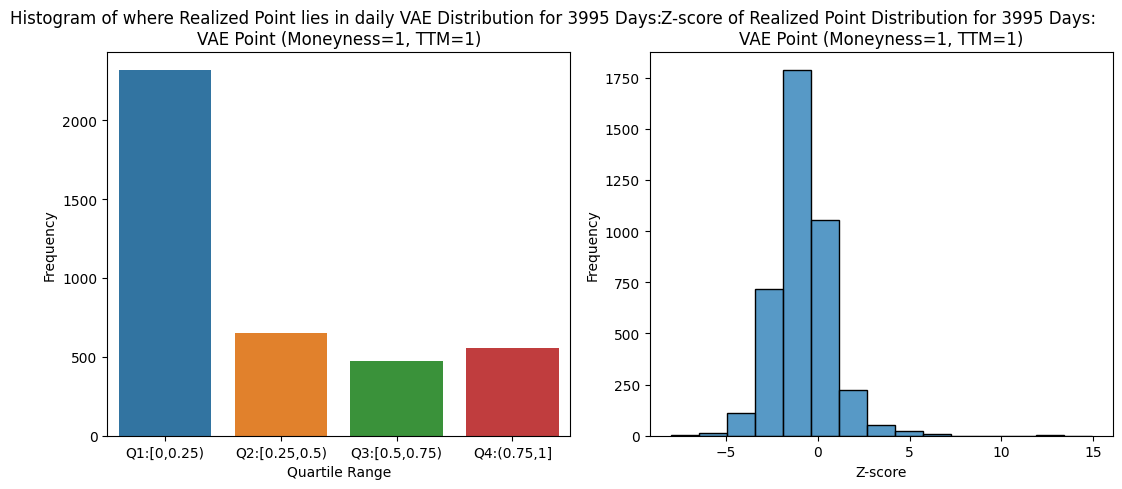

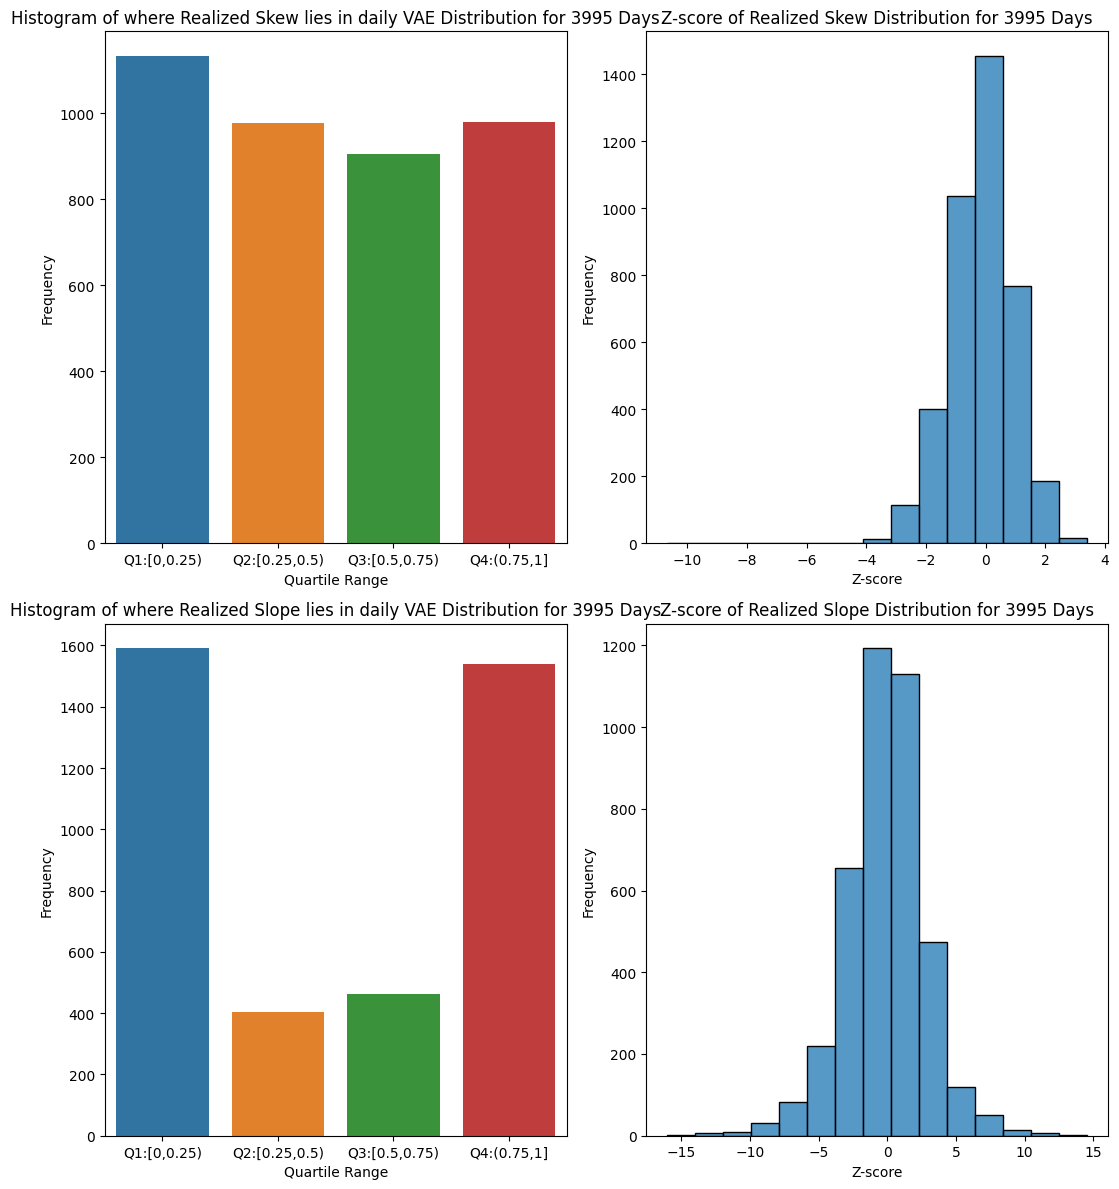

In [10]:
if not os.path.exists("test_spx/conv_mem_spx_ex3_0_gen4.npy"):
    surfaces, _ = generate_surfaces_multiday(model_data = model_data,
        ex_data = ex_data, vol_surface_data = vol_surf_data,
        start_day=start_day, days_to_generate=days_to_generate, num_vaes = num_vaes,
        model_type = CVAEMemRand, check_ex_feats=False, ctx_len=4)
    np.save("test_spx/conv_mem_spx_ex3_0_gen4.npy", surfaces)
else:
    surfaces = np.load("test_spx/conv_mem_spx_ex3_0_gen4.npy")

print(surfaces.shape)
_ = generate_multiple_surfaces_day_evolution_pre_gen(pre_generated_data={"surface": surfaces},
                                             vol_surface_data = vol_surf_data[start_day:start_day+days_to_generate],
                                             ex_data=ex_data[start_day:start_day+days_to_generate],
                                             row=3, col=2, check_ex_feats=False, bin_count=15)
_ = skew_and_slope_daily_evolution_pre_gen(pre_generated_data={"surface": surfaces},
                                           vol_surface_data=vol_surf_data[start_day:start_day+days_to_generate],
                                            bin_count=15)

(3995, 1000, 5, 5)


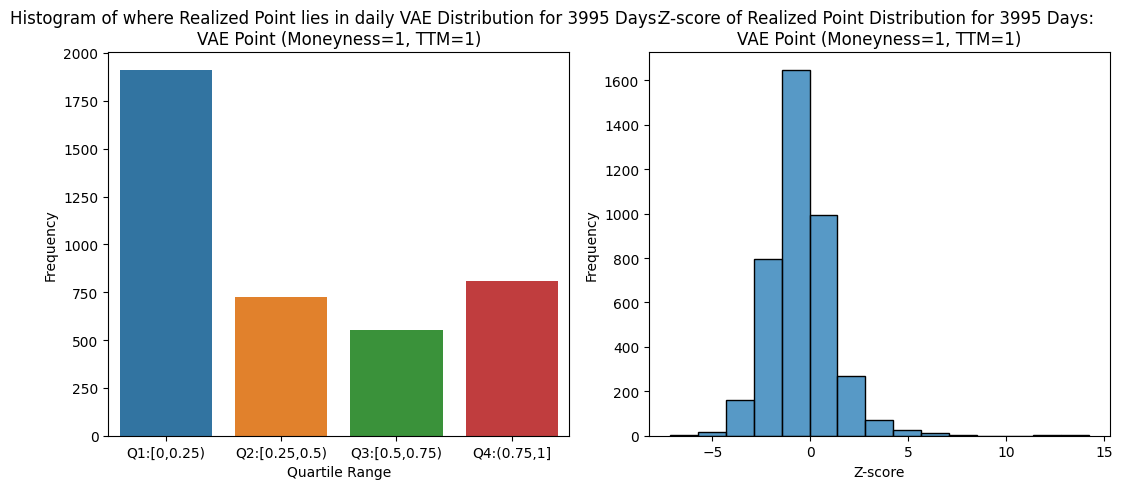

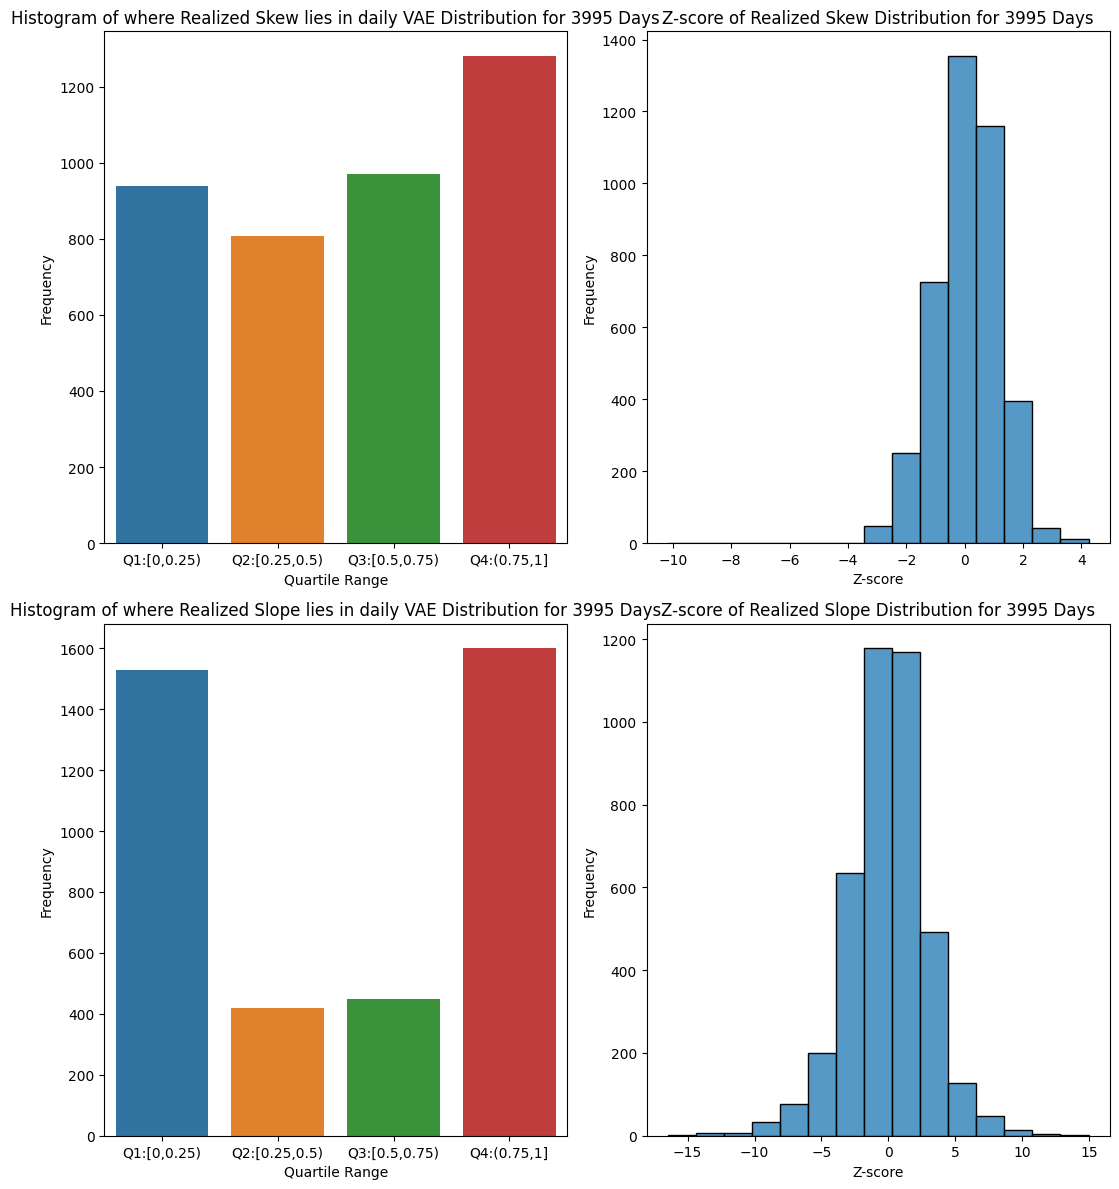

In [11]:
if not os.path.exists("test_spx/conv_mem_spx_ex3_0_gen5.npy"):
    surfaces, _ = generate_surfaces_multiday(model_data = model_data,
        ex_data = ex_data, vol_surface_data = vol_surf_data,
        start_day=start_day, days_to_generate=days_to_generate, num_vaes = num_vaes,
        model_type = CVAEMemRand, check_ex_feats=False, ctx_len=5)
    np.save("test_spx/conv_mem_spx_ex3_0_gen5.npy", surfaces)
else:
    surfaces = np.load("test_spx/conv_mem_spx_ex3_0_gen5.npy")

print(surfaces.shape)
_ = generate_multiple_surfaces_day_evolution_pre_gen(pre_generated_data={"surface": surfaces},
                                             vol_surface_data = vol_surf_data[start_day:start_day+days_to_generate],
                                             ex_data=ex_data[start_day:start_day+days_to_generate],
                                             row=3, col=2, check_ex_feats=False, bin_count=15)
_ = skew_and_slope_daily_evolution_pre_gen(pre_generated_data={"surface": surfaces},
                                           vol_surface_data=vol_surf_data[start_day:start_day+days_to_generate],
                                            bin_count=15)

In [12]:
model_data = torch.load("test_spx/ex_3_feats/conv_mem_spx_ex3_1.pt") # latent_dim=5, surface_hidden=[5,5,5], mem_hidden=100
model_config = model_data["model_config"]
model = CVAEMemRand(model_config)
model.load_weights(dict_to_load=model_data)
print(model)

CVAEMemRand(
  (encoder): CVAEMemRandEncoder(
    (surface_embedding): Sequential(
      (enc_conv_0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_0): ReLU()
      (enc_conv_1): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_1): ReLU()
      (enc_conv_2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (enc_activation_2): ReLU()
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (ex_feats_embedding): Identity()
    (interaction): Identity()
    (mem): LSTM(128, 100, num_layers=2, batch_first=True, dropout=0.2)
    (z_mean_layer): Linear(in_features=100, out_features=5, bias=True)
    (z_log_var_layer): Linear(in_features=100, out_features=5, bias=True)
  )
  (ctx_encoder): CVAECtxMemRandEncoder(
    (ctx_surface_embedding): Sequential(
      (ctx_enc_conv_0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (ctx_enc_activation_0): ReLU()
      (ctx_enc_co

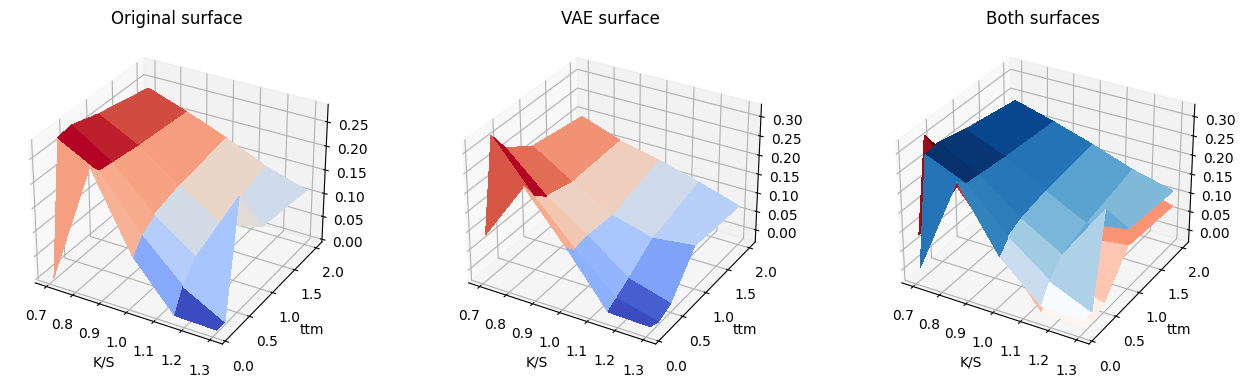

In [13]:
surf, ex_feat = model.get_surface_given_conditions({"surface": torch.from_numpy(vol_surf_data[5000:5004]),
                                    "ex_feats": torch.from_numpy(ex_data[5000:5004])})
surf = surf.detach().cpu().numpy().reshape((5,5))
# ex_feat = ex_feat.detach().cpu().numpy().reshape((1,))[0]
# print(f"Real return: {ret_data[5000+ctx_len]}, predicted: {ex_feat}")
plot_surface_separate(vol_surf_data[5004], surf)

(3995, 1000, 5, 5)
(3995, 1000, 3)


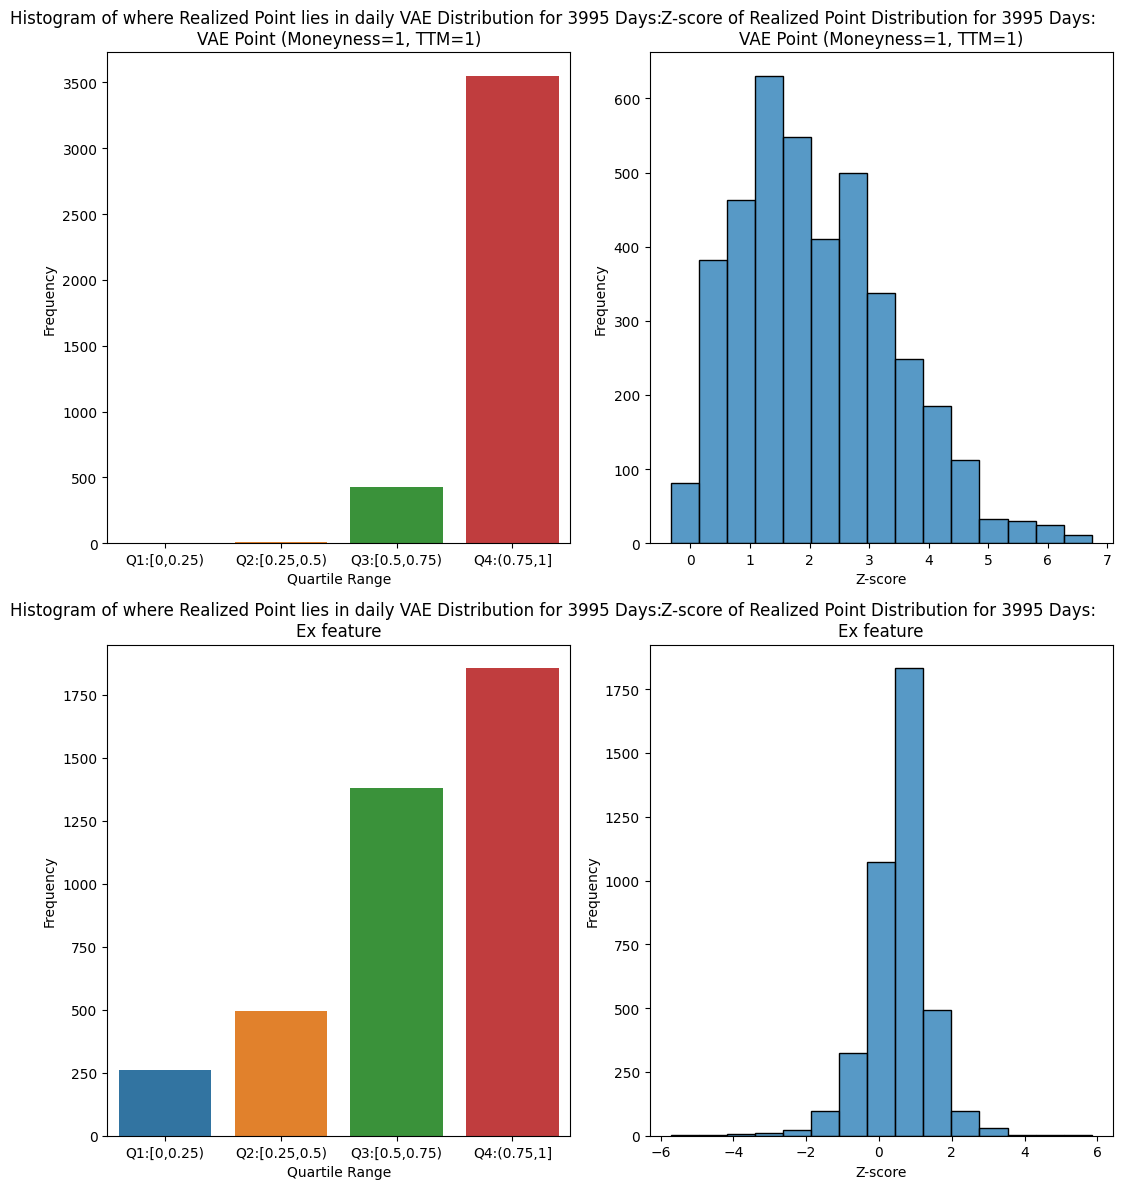

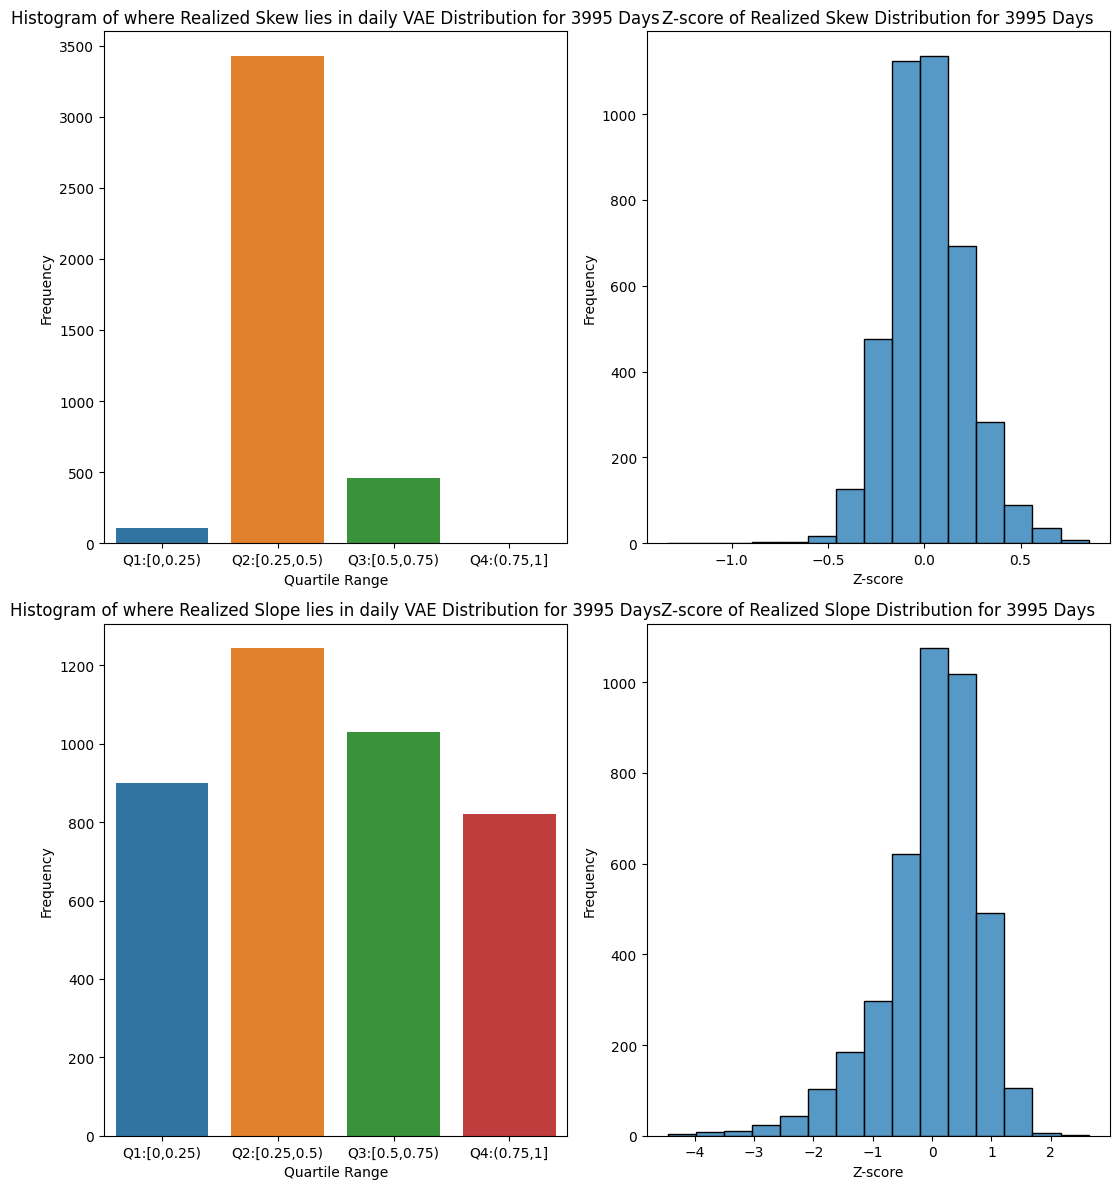

In [14]:
if not os.path.exists("test_spx/conv_mem_spx_ex3_1_gen2.npz"):
    surfaces, ex_feats = generate_surfaces_multiday(model_data = model_data,
        ex_data = ex_data, vol_surface_data = vol_surf_data,
        start_day=start_day, days_to_generate=days_to_generate, num_vaes = num_vaes,
        model_type = CVAEMemRand, check_ex_feats=True, ctx_len=2)
    np.savez("test_spx/conv_mem_spx_ex3_1_gen2.npz", surfaces=surfaces, ex_feats=ex_feats)
else:
    data = np.load("test_spx/conv_mem_spx_ex3_1_gen2.npz")
    surfaces = data["surfaces"]
    ex_feats = data["ex_feats"]

print(surfaces.shape)
print(ex_feats.shape)
_ = generate_multiple_surfaces_day_evolution_pre_gen(pre_generated_data={"surface": surfaces, "ex_feats": ex_feats[:,:,0]},
                                             vol_surface_data = vol_surf_data[start_day:start_day+days_to_generate],
                                             ex_data=ex_data[start_day:start_day+days_to_generate,0],
                                             row=3, col=2, check_ex_feats=True, bin_count=15)
_ = skew_and_slope_daily_evolution_pre_gen(pre_generated_data={"surface": surfaces, "ex_feats": ex_feats[:,:,0]},
                                           vol_surface_data=vol_surf_data[start_day:start_day+days_to_generate],
                                            bin_count=15)

(3995, 1000, 5, 5)
(3995, 1000, 3)


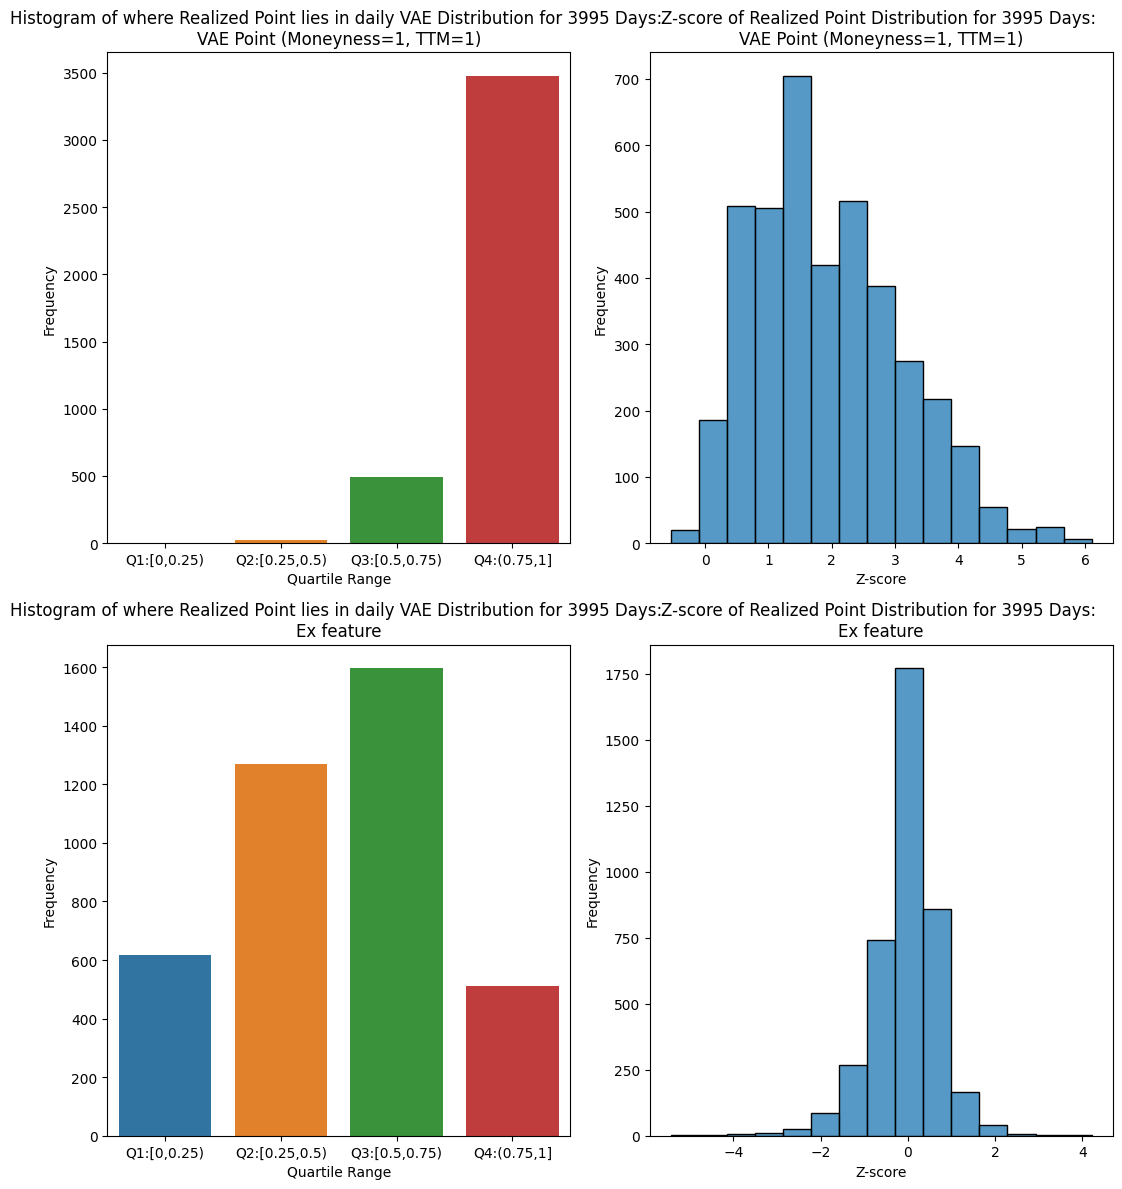

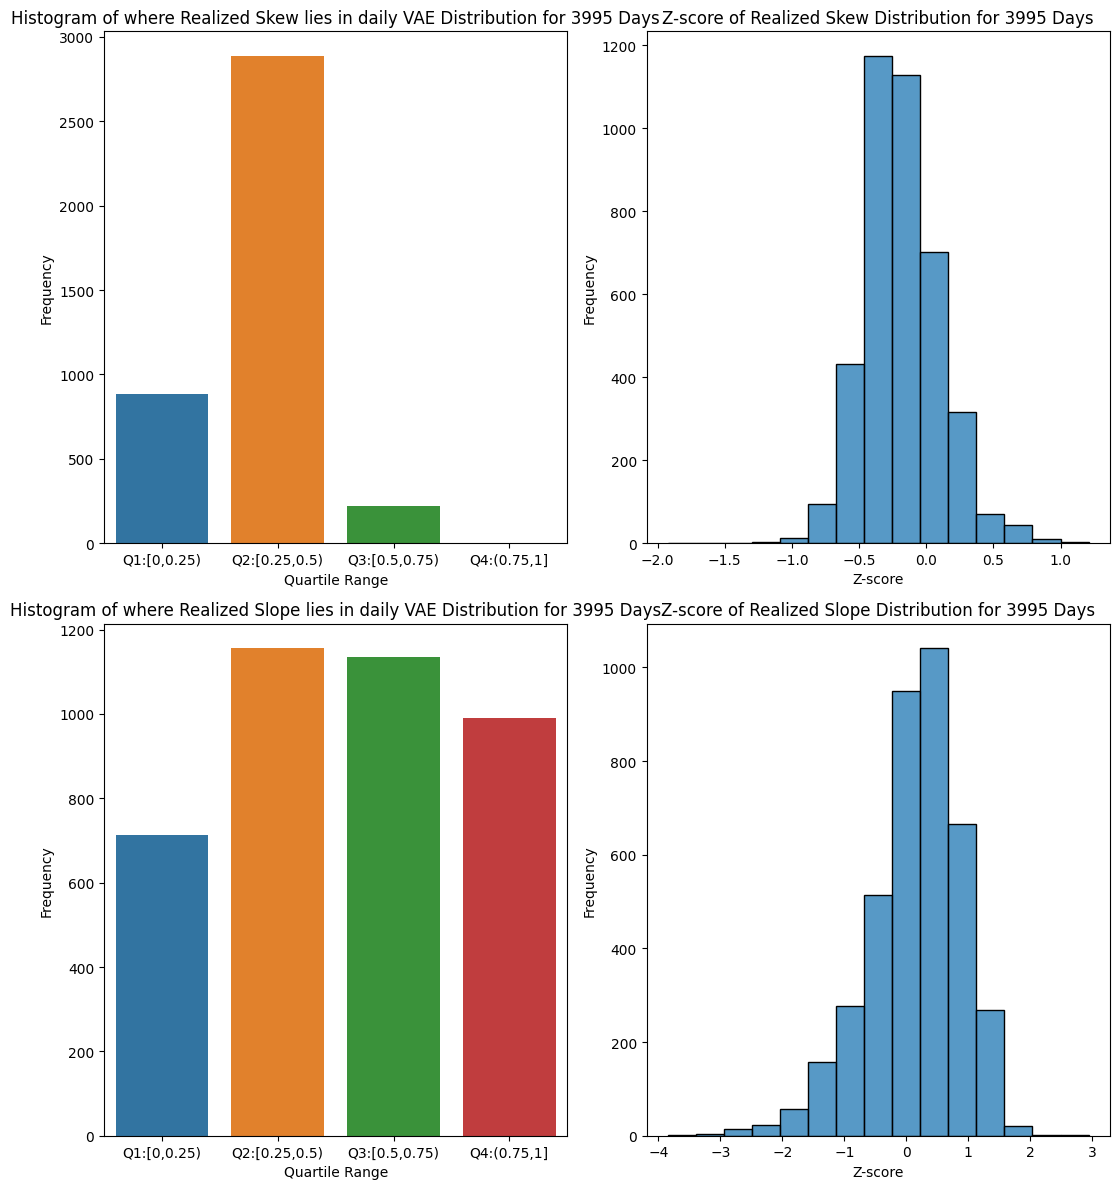

In [15]:
if not os.path.exists("test_spx/conv_mem_spx_ex3_1_gen3.npz"):
    surfaces, ex_feats = generate_surfaces_multiday(model_data = model_data,
        ex_data = ex_data, vol_surface_data = vol_surf_data,
        start_day=start_day, days_to_generate=days_to_generate, num_vaes = num_vaes,
        model_type = CVAEMemRand, check_ex_feats=True, ctx_len=3)
    np.savez("test_spx/conv_mem_spx_ex3_1_gen3.npz", surfaces=surfaces, ex_feats=ex_feats)
else:
    data = np.load("test_spx/conv_mem_spx_ex3_1_gen3.npz")
    surfaces = data["surfaces"]
    ex_feats = data["ex_feats"]

print(surfaces.shape)
print(ex_feats.shape)
_ = generate_multiple_surfaces_day_evolution_pre_gen(pre_generated_data={"surface": surfaces, "ex_feats": ex_feats[:,:,0]},
                                             vol_surface_data = vol_surf_data[start_day:start_day+days_to_generate],
                                             ex_data=ex_data[start_day:start_day+days_to_generate,0],
                                             row=3, col=2, check_ex_feats=True, bin_count=15)
_ = skew_and_slope_daily_evolution_pre_gen(pre_generated_data={"surface": surfaces, "ex_feats": ex_feats[:,:,0]},
                                           vol_surface_data=vol_surf_data[start_day:start_day+days_to_generate],
                                            bin_count=15)

(3995, 1000, 5, 5)
(3995, 1000, 3)


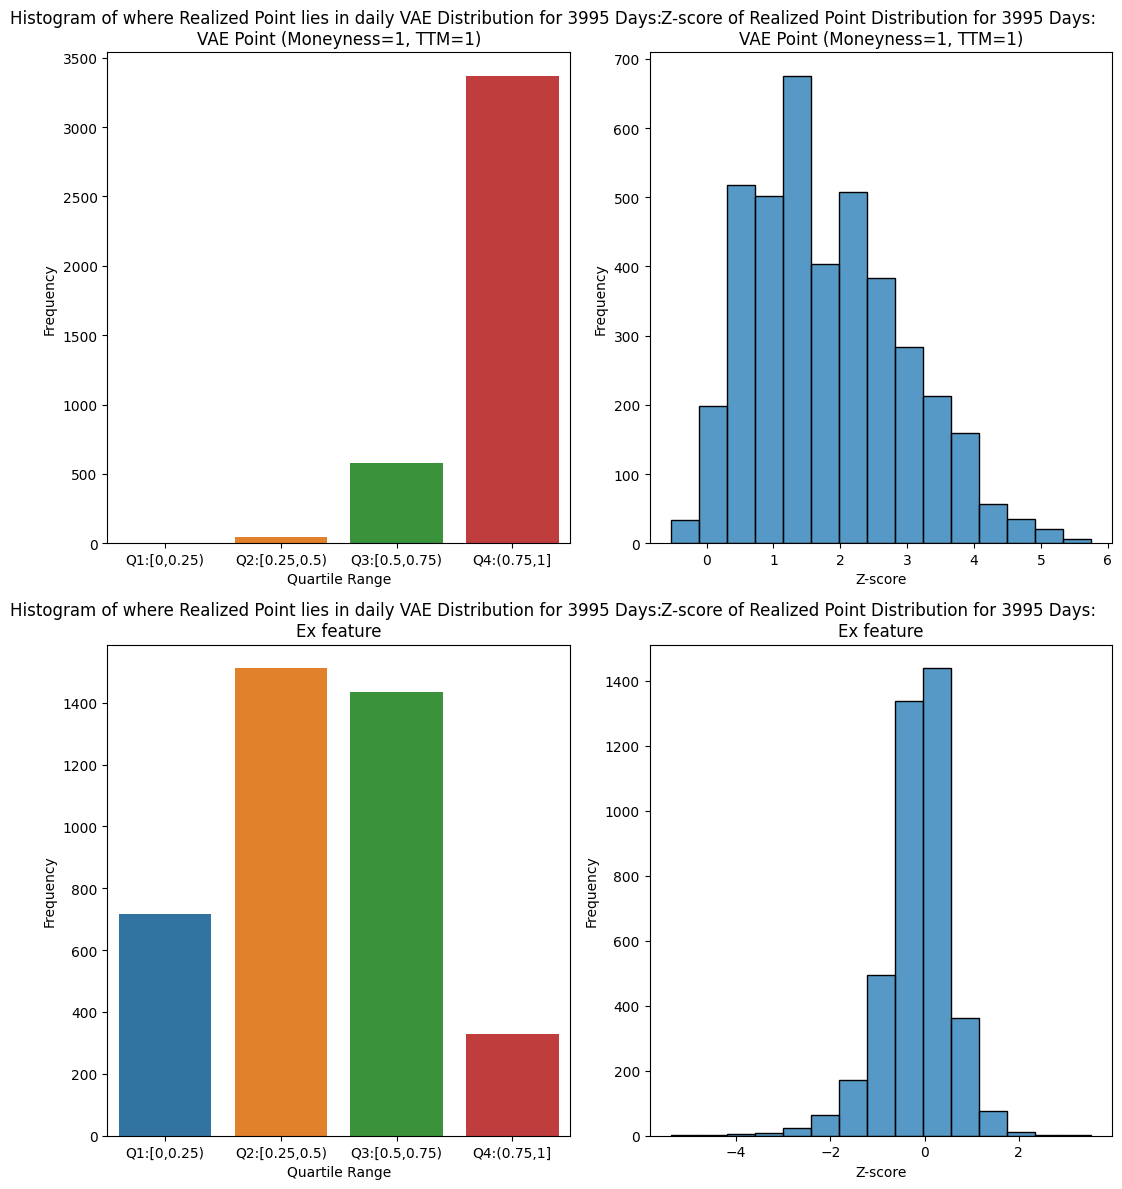

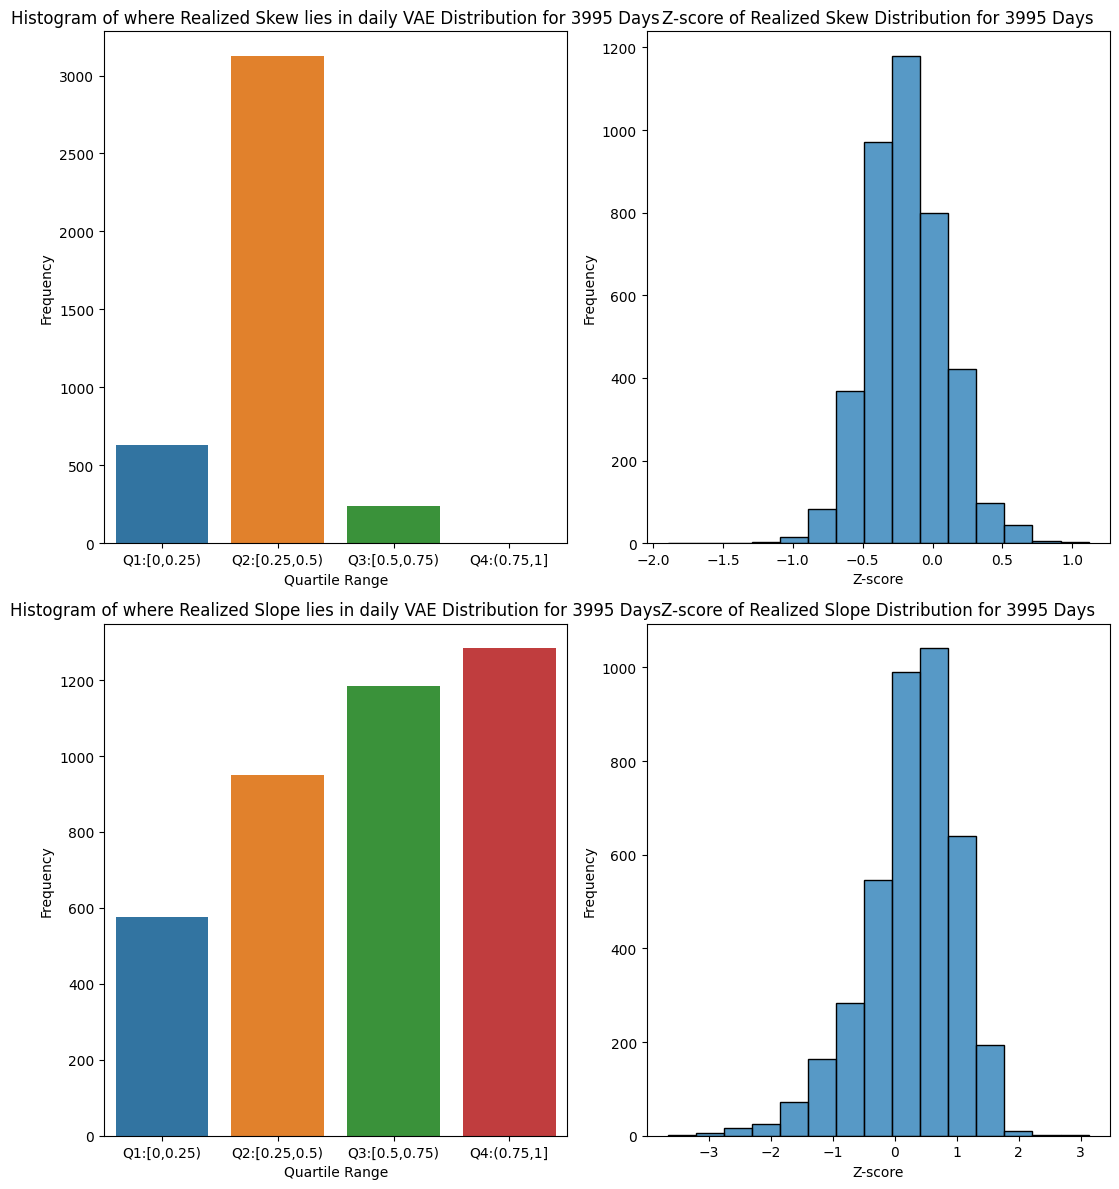

In [16]:
if not os.path.exists("test_spx/conv_mem_spx_ex3_1_gen4.npz"):
    surfaces, ex_feats = generate_surfaces_multiday(model_data = model_data,
        ex_data = ex_data, vol_surface_data = vol_surf_data,
        start_day=start_day, days_to_generate=days_to_generate, num_vaes = num_vaes,
        model_type = CVAEMemRand, check_ex_feats=True, ctx_len=4)
    np.savez("test_spx/conv_mem_spx_ex3_1_gen4.npz", surfaces=surfaces, ex_feats=ex_feats)
else:
    data = np.load("test_spx/conv_mem_spx_ex3_1_gen4.npz")
    surfaces = data["surfaces"]
    ex_feats = data["ex_feats"]

print(surfaces.shape)
print(ex_feats.shape)
_ = generate_multiple_surfaces_day_evolution_pre_gen(pre_generated_data={"surface": surfaces, "ex_feats": ex_feats[:,:,0]},
                                             vol_surface_data = vol_surf_data[start_day:start_day+days_to_generate],
                                             ex_data=ex_data[start_day:start_day+days_to_generate,0],
                                             row=3, col=2, check_ex_feats=True, bin_count=15)
_ = skew_and_slope_daily_evolution_pre_gen(pre_generated_data={"surface": surfaces, "ex_feats": ex_feats[:,:,0]},
                                           vol_surface_data=vol_surf_data[start_day:start_day+days_to_generate],
                                            bin_count=15)

(3995, 1000, 5, 5)
(3995, 1000, 3)


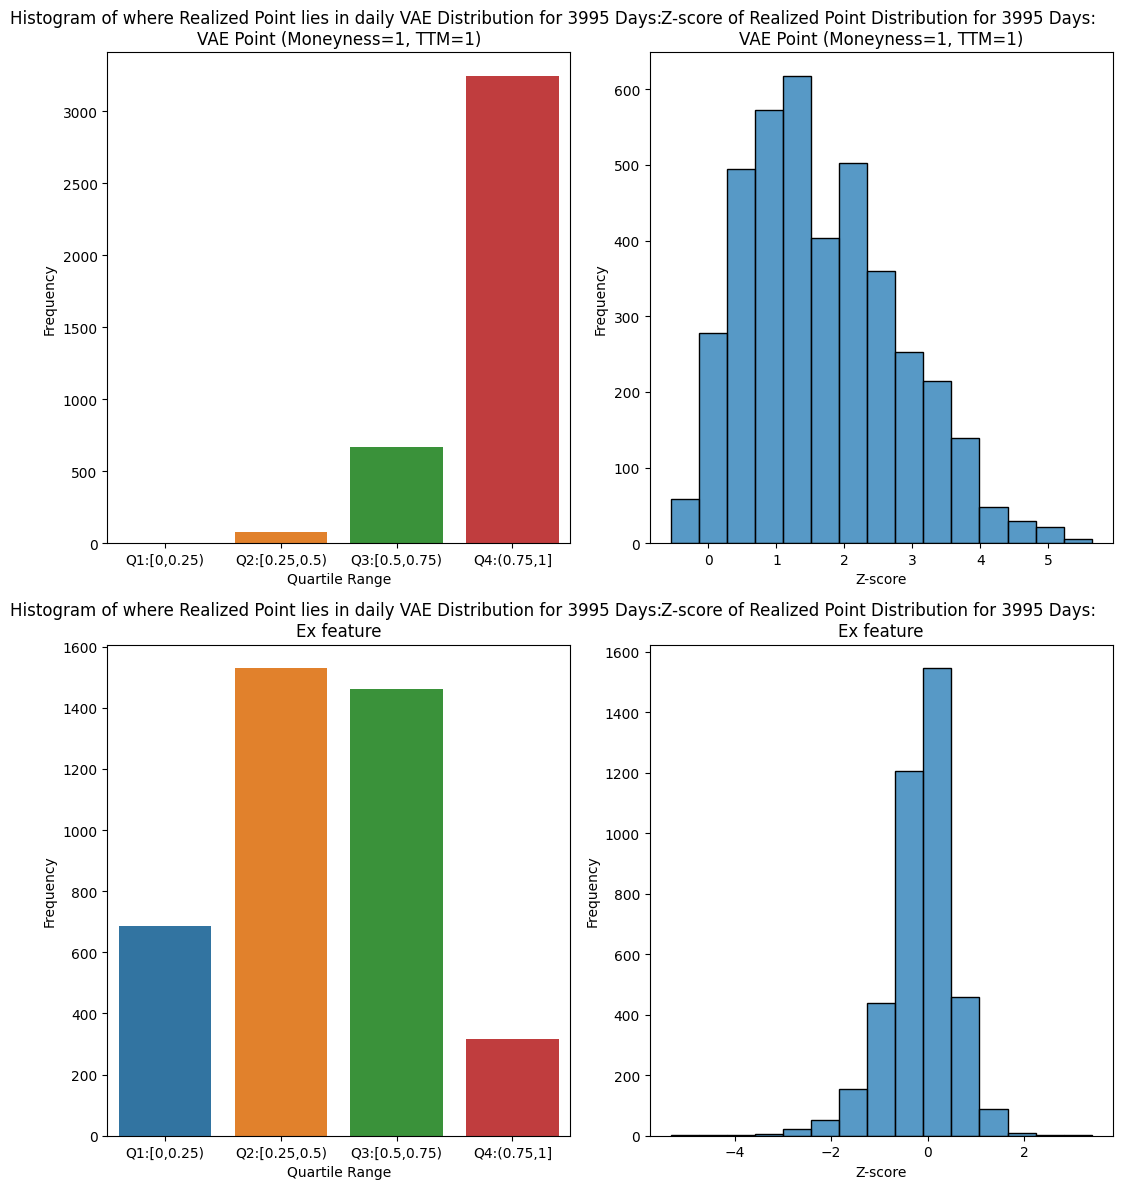

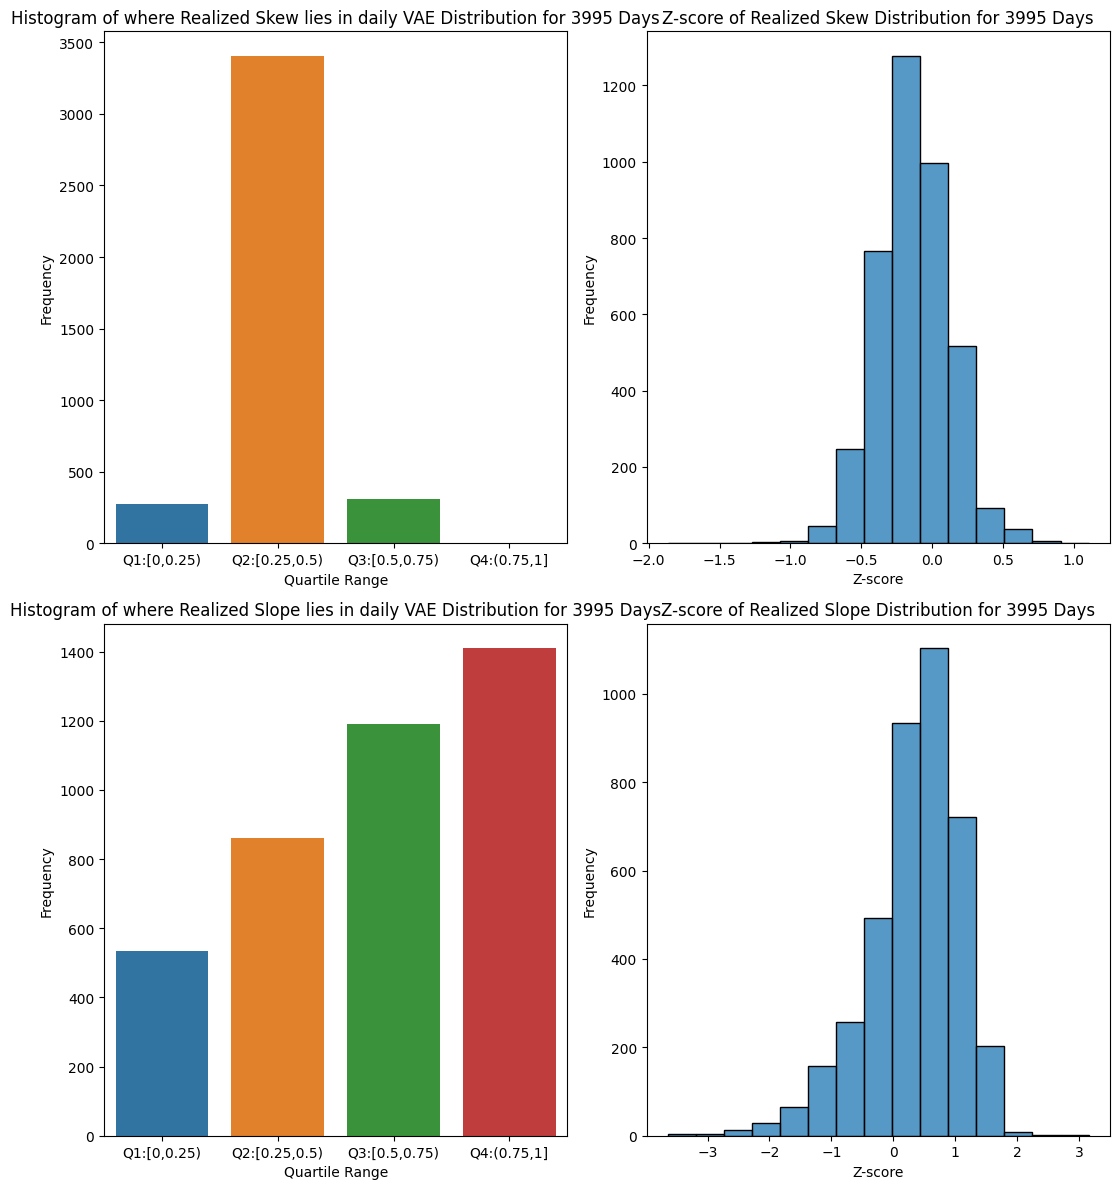

In [17]:
if not os.path.exists("test_spx/conv_mem_spx_ex3_1_gen5.npz"):
    surfaces, ex_feats = generate_surfaces_multiday(model_data = model_data,
        ex_data = ex_data, vol_surface_data = vol_surf_data,
        start_day=start_day, days_to_generate=days_to_generate, num_vaes = num_vaes,
        model_type = CVAEMemRand, check_ex_feats=True, ctx_len=5)
    np.savez("test_spx/conv_mem_spx_ex3_1_gen5.npz", surfaces=surfaces, ex_feats=ex_feats)
else:
    data = np.load("test_spx/conv_mem_spx_ex3_1_gen5.npz")
    surfaces = data["surfaces"]
    ex_feats = data["ex_feats"]

print(surfaces.shape)
print(ex_feats.shape)
_ = generate_multiple_surfaces_day_evolution_pre_gen(pre_generated_data={"surface": surfaces, "ex_feats": ex_feats[:,:,0]},
                                             vol_surface_data = vol_surf_data[start_day:start_day+days_to_generate],
                                             ex_data=ex_data[start_day:start_day+days_to_generate,0],
                                             row=3, col=2, check_ex_feats=True, bin_count=15)
_ = skew_and_slope_daily_evolution_pre_gen(pre_generated_data={"surface": surfaces, "ex_feats": ex_feats[:,:,0]},
                                           vol_surface_data=vol_surf_data[start_day:start_day+days_to_generate],
                                            bin_count=15)